## Tabular Prototype - Machine Learning
### Classifying Waterborne Disease Counts Using Global Water Quality and Socioeconomic Indicators
---

RECAP of EDA Observations  & Interpretation:
- No outliers; weak/no linear correlation; random scatterplots
    - Simple linear models will struggle. For baseline models, tree-based models will be attempted.
- Things to consider/do:
    - Feature engineering since majority of numerical feature correlations are low (<0.04)
    - Encode categorical features
----
#### Problem Formulation 
- No duplicates

In [84]:
# importing libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler


from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
import lightgbm as lgb
from catboost import CatBoostRegressor

In [5]:
# load in dataset
df_base = pd.read_csv('df_baseline.csv')  

df_base.head()

,Country,Region,Year,Water Source Type,Contaminant Level (ppm),pH Level,Turbidity (NTU),Dissolved Oxygen (mg/L),Nitrate Level (mg/L),Lead Concentration (µg/L),...,"Cholera Cases per 100,000 people","Typhoid Cases per 100,000 people","Infant Mortality Rate (per 1,000 live births)",GDP per Capita (USD),Healthcare Access Index (0-100),Urbanization Rate (%),Sanitation Coverage (% of Population),Rainfall (mm per year),Temperature (°C),Population Density (people per km²)
0,Mexico,North,2015,Lake,6.06,7.12,3.93,4.28,8.28,7.89,...,33,44,76.16,57057,96.92,84.61,63.23,2800,4.94,593
1,Brazil,West,2017,Well,5.24,7.84,4.79,3.86,15.74,14.68,...,27,8,77.30,17220,84.73,73.37,29.12,1572,16.93,234
2,Indonesia,Central,2022,Pond,0.24,6.43,0.79,3.42,36.67,9.96,...,39,50,48.45,86022,58.37,72.86,93.56,2074,21.73,57
3,Nigeria,East,2016,Well,7.91,6.71,1.96,3.12,36.92,6.77,...,33,13,95.66,31166,39.07,71.07,94.25,937,3.79,555
4,Mexico,South,2005,Well,0.12,8.16,4.22,9.15,49.35,12.51,...,31,68,58.78,25661,23.03,55.55,69.23,2295,31.44,414


In [7]:
# check datatypes
df_base.dtypes

Country                                           object
Region                                            object
Year                                               int64
Water Source Type                                 object
Contaminant Level (ppm)                          float64
pH Level                                         float64
Turbidity (NTU)                                  float64
Dissolved Oxygen (mg/L)                          float64
Nitrate Level (mg/L)                             float64
Lead Concentration (µg/L)                        float64
Bacteria Count (CFU/mL)                            int64
Water Treatment Method                            object
Access to Clean Water (% of Population)          float64
Diarrheal Cases per 100,000 people                 int64
Cholera Cases per 100,000 people                   int64
Typhoid Cases per 100,000 people                   int64
Infant Mortality Rate (per 1,000 live births)    float64
GDP per Capita (USD)           

In [9]:
# checking for duplicate rows
num_duplicates = df_base.duplicated().sum()

print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


-------
#### Base models (Random Forest Regressor & XGBoost)

In [12]:
# target cols
target_cols = [
    'Diarrheal Cases per 100,000 people',
    'Cholera Cases per 100,000 people',
    'Typhoid Cases per 100,000 people'
]

# categorical and numerical features
cat_cols = ['Country', 'Region', 'Water Source Type', 'Water Treatment Method']
num_cols = [col for col in df_base.columns if col not in cat_cols + target_cols + ['Year']]

print("Categorical Features:", cat_cols)
print("\n\nNumerical Features:", num_cols)

Categorical Features: ['Country', 'Region', 'Water Source Type', 'Water Treatment Method']


Numerical Features: ['Contaminant Level (ppm)', 'pH Level', 'Turbidity (NTU)', 'Dissolved Oxygen (mg/L)', 'Nitrate Level (mg/L)', 'Lead Concentration (µg/L)', 'Bacteria Count (CFU/mL)', 'Access to Clean Water (% of Population)', 'Infant Mortality Rate (per 1,000 live births)', 'GDP per Capita (USD)', 'Healthcare Access Index (0-100)', 'Urbanization Rate (%)', 'Sanitation Coverage (% of Population)', 'Rainfall (mm per year)', 'Temperature (°C)', 'Population Density (people per km²)']


In [14]:
# try a basline model 

X = df_base[cat_cols + num_cols]
y = df_base[target_cols]

print(X.shape)
print(y.shape)

(3000, 20)
(3000, 3)


In [16]:
# train/split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)

Train Shape: (2400, 20)
Test Shape: (600, 20)


In [18]:
# one hot encoding
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# define ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='passthrough'  # keeps numl cols as it is
)

# fit on training data
preprocessor.fit(X_train)

# transform both train and test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Processed Train Shape:", X_train_processed.shape)
print("Processed Test Shape:", X_test_processed.shape)

Processed Train Shape: (2400, 41)
Processed Test Shape: (600, 41)


In [20]:
# check feature names
encoded_feature_names = preprocessor.get_feature_names_out()
encoded_feature_names

array(['cat__Country_Bangladesh', 'cat__Country_Brazil',
       'cat__Country_China', 'cat__Country_Ethiopia',
       'cat__Country_India', 'cat__Country_Indonesia',
       'cat__Country_Mexico', 'cat__Country_Nigeria',
       'cat__Country_Pakistan', 'cat__Country_USA', 'cat__Region_Central',
       'cat__Region_East', 'cat__Region_North', 'cat__Region_South',
       'cat__Region_West', 'cat__Water Source Type_Lake',
       'cat__Water Source Type_Pond', 'cat__Water Source Type_River',
       'cat__Water Source Type_Spring', 'cat__Water Source Type_Tap',
       'cat__Water Source Type_Well',
       'cat__Water Treatment Method_Boiling',
       'cat__Water Treatment Method_Chlorination',
       'cat__Water Treatment Method_Filtration',
       'cat__Water Treatment Method_Unknown',
       'remainder__Contaminant Level (ppm)', 'remainder__pH Level',
       'remainder__Turbidity (NTU)', 'remainder__Dissolved Oxygen (mg/L)',
       'remainder__Nitrate Level (mg/L)',
       'remainder__Lead

In [22]:
# base random forest regressor

# to store models and results
base_rfr = {}
base_rfr_results = {}

# gothrough ea. target
for target in y_train.columns:
    print(f"\n=== Training model for: {target} ===")
    
    # train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_processed, y_train[target])
    
    # predit
    y_pred = model.predict(X_test_processed)
    
    # metrics
    mae = mean_absolute_error(y_test[target], y_pred)
    rmse = np.sqrt(mean_squared_error(y_test[target], y_pred))
    r2 = r2_score(y_test[target], y_pred)
    
    # scores
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.3f}")
    
    # store model and results
    base_rfr[target] = model
    base_rfr_results[target] = {'MAE': mae, '\nRMSE': rmse, '\nR2': r2}


=== Training model for: Diarrheal Cases per 100,000 people ===
MAE:  129.37
RMSE: 148.68
R²:   -0.040

=== Training model for: Cholera Cases per 100,000 people ===
MAE:  12.58
RMSE: 14.59
R²:   -0.035

=== Training model for: Typhoid Cases per 100,000 people ===
MAE:  25.36
RMSE: 29.22
R²:   -0.017


In [24]:
pd.DataFrame(base_rfr_results).T

,MAE,\nRMSE,\nR2
"Diarrheal Cases per 100,000 people",129.370100,148.676050,-0.039980
"Cholera Cases per 100,000 people",12.575867,14.593917,-0.034562
"Typhoid Cases per 100,000 people",25.362633,29.219737,-0.017304


Notes:
- All have negative R^2, indicating they perform worse than simply predicting the mean
- The errors (MAE, RMSE) values are high relative to the scale of each target (129 for diarrheal vs. 12–25 for the other diseases), suggesting large absolute prediction errors
- Results at the moment poor predictive power and indicate the need for better feature engineering and model tuning
----

In [27]:
# loop to print top 10 features for all 3 diseases
feature_names = preprocessor.get_feature_names_out()

for target in base_rfr.keys():
    print(f"\n=== Top 10 Features for: {target} ===")
    
    model = base_rfr[target]
    
    # feature importances as an array
    importances = model.feature_importances_
    
    # zip with feature names
    importance_list = list(zip(feature_names, importances))
    
    # descending order 
    importance_list_sorted = sorted(importance_list, key=lambda x: x[1], reverse=True)
    
    for feature, importance in importance_list_sorted[:10]:
        print(f"{feature}: {importance:.4f}")


=== Top 10 Features for: Diarrheal Cases per 100,000 people ===
remainder__Rainfall (mm per year): 0.0610
remainder__Contaminant Level (ppm): 0.0605
remainder__Nitrate Level (mg/L): 0.0580
remainder__Bacteria Count (CFU/mL): 0.0576
remainder__Urbanization Rate (%): 0.0568
remainder__Healthcare Access Index (0-100): 0.0563
remainder__Sanitation Coverage (% of Population): 0.0562
remainder__Population Density (people per km²): 0.0548
remainder__Dissolved Oxygen (mg/L): 0.0547
remainder__Turbidity (NTU): 0.0545

=== Top 10 Features for: Cholera Cases per 100,000 people ===
remainder__Nitrate Level (mg/L): 0.0593
remainder__Infant Mortality Rate (per 1,000 live births): 0.0589
remainder__Contaminant Level (ppm): 0.0586
remainder__Turbidity (NTU): 0.0578
remainder__GDP per Capita (USD): 0.0569
remainder__Lead Concentration (µg/L): 0.0568
remainder__Healthcare Access Index (0-100): 0.0565
remainder__Urbanization Rate (%): 0.0563
remainder__Dissolved Oxygen (mg/L): 0.0555
remainder__Temperat

Notes:
- Water quality and socioeconomic variables (Nitrate, Contaminant Level, Healthcare Access, GDP) show consistent importance across diseases
- Theres no dominant predictor: importance values are close (5–6%)
----

In [30]:
# base xgb
xgb_base = {}
base_xgb_results = {}

for target in y_train.columns:
    print(f"\n=== Training XGBoost for: {target} ===")
    
    model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_processed, y_train[target])
    
    y_pred = model.predict(X_test_processed)
    
    mae = mean_absolute_error(y_test[target], y_pred)
    rmse = np.sqrt(mean_squared_error(y_test[target], y_pred))
    r2 = r2_score(y_test[target], y_pred)
    
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.3f}")
    
    xgb_base[target] = model
    base_xgb_results[target] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}


=== Training XGBoost for: Diarrheal Cases per 100,000 people ===
MAE:  133.28
RMSE: 158.70
R²:   -0.185

=== Training XGBoost for: Cholera Cases per 100,000 people ===
MAE:  13.21
RMSE: 15.66
R²:   -0.191

=== Training XGBoost for: Typhoid Cases per 100,000 people ===
MAE:  27.98
RMSE: 32.53
R²:   -0.261


In [32]:
pd.DataFrame(base_xgb_results).T

,MAE,RMSE,R2
"Diarrheal Cases per 100,000 people",133.280441,158.698115,-0.184913
"Cholera Cases per 100,000 people",13.208580,15.656380,-0.190681
"Typhoid Cases per 100,000 people",27.980326,32.529045,-0.260785


In [34]:
# loop to print top 10 features for all 3 diseases
feature_names = preprocessor.get_feature_names_out()

for target in xgb_base.keys():
    print(f"\n=== Top 10 Features for: {target} ===")
    
    model = xgb_base[target]
    
    # feature importances as an array
    importances = model.feature_importances_
    
    # zip with feature names
    importance_list = list(zip(feature_names, importances))
    
    # descending order 
    importance_list_sorted = sorted(importance_list, key=lambda x: x[1], reverse=True)
    
    for feature, importance in importance_list_sorted[:10]:
        print(f"{feature}: {importance:.4f}")


=== Top 10 Features for: Diarrheal Cases per 100,000 people ===
remainder__Bacteria Count (CFU/mL): 0.0419
cat__Water Treatment Method_Chlorination: 0.0406
remainder__Rainfall (mm per year): 0.0405
remainder__Healthcare Access Index (0-100): 0.0373
remainder__Sanitation Coverage (% of Population): 0.0371
remainder__Infant Mortality Rate (per 1,000 live births): 0.0368
remainder__Nitrate Level (mg/L): 0.0366
remainder__Dissolved Oxygen (mg/L): 0.0365
remainder__Access to Clean Water (% of Population): 0.0365
remainder__Turbidity (NTU): 0.0356

=== Top 10 Features for: Cholera Cases per 100,000 people ===
remainder__Turbidity (NTU): 0.0413
remainder__Dissolved Oxygen (mg/L): 0.0400
remainder__Population Density (people per km²): 0.0400
remainder__Infant Mortality Rate (per 1,000 live births): 0.0393
remainder__Rainfall (mm per year): 0.0382
remainder__Urbanization Rate (%): 0.0376
remainder__Healthcare Access Index (0-100): 0.0374
remainder__pH Level: 0.0369
remainder__Access to Clean W

Notes:
- Performance still poor (all R^2 < 0)with XGBoost. The model can't explain variance well.
- Feature importance is spread out, top features like Bacteria Count, Water Treatment, Rainfall account for only about 4%, indicating no strong single driver
- Categorical splits show some value (Water Treatment types, Regions), but overall signal is **fragmented and subtle**

----

#### Trying some Hyperparameter Tuning
- Focusing on tuning XGBoost because it’s more likely to improve results and uncover hidden patterns in this dataset

In [37]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
}

xgb_base_reg = xgb.XGBRegressor(random_state=42)

search = RandomizedSearchCV(
    estimator=xgb_base_reg,
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train_processed, y_train['Diarrheal Cases per 100,000 people'])

print("Best params:", search.best_params_)
print("Best score (neg MAE):", search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01}
Best score (neg MAE): -124.33983866373698


Notes: 
- very low learning rate (0.01)
-----

#### Multi-output Regression with XGBoost
Instead of training separate models for each disease, multi-output regression can use one model to predict all outcomes at once. This method can find shared patterns between the diseases (like areas with high diarrheal rates also having higher cholera rates). It can boost performance when targets are related, even slightly.

In [41]:
# wrap cgboost in multiouput regressor to handle the targets
multi_xgb_model = MultiOutputRegressor(
    xgb.XGBRegressor(
        n_estimators=100, 
        learning_rate=0.01, 
        max_depth=7, 
        subsample=0.6, 
        random_state=42
    )
)

# fit on entire training data (all targets at once)
multi_xgb_model.fit(X_train_processed, y_train)

y_pred_multi = multi_xgb_model.predict(X_test_processed)


# evaluate for ea. target
for idx, target in enumerate(y_train.columns):
    print(f"\n=== {target} ===")
    mae = mean_absolute_error(y_test[target], y_pred_multi[:, idx])
    rmse = np.sqrt(mean_squared_error(y_test[target], y_pred_multi[:, idx]))
    r2 = r2_score(y_test[target], y_pred_multi[:, idx])
    
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.3f}")


=== Diarrheal Cases per 100,000 people ===
MAE:  127.91
RMSE: 146.71
R²:   -0.013

=== Cholera Cases per 100,000 people ===
MAE:  12.39
RMSE: 14.37
R²:   -0.003

=== Typhoid Cases per 100,000 people ===
MAE:  25.37
RMSE: 29.03
R²:   -0.004


Notes:
- Slight improvement in R^2 scores (closer to 0)
- Relationships in the data are subtle and spread out, but multi-output regression is a bit better choice to go

-----

#### Feature Engineering Time


In [45]:
# lets check for skews

# numerical cols 
num_cols = df_base.select_dtypes(include=[np.number]).columns
num_features = [col for col in num_cols if col not in target_cols]

# compute skewness
skew_vals = df_base[num_features].skew().sort_values(ascending=False)
print(skew_vals)

Turbidity (NTU)                                  0.047479
GDP per Capita (USD)                             0.029165
Infant Mortality Rate (per 1,000 live births)    0.021184
Nitrate Level (mg/L)                             0.018850
Access to Clean Water (% of Population)          0.017730
Dissolved Oxygen (mg/L)                          0.015727
Bacteria Count (CFU/mL)                          0.010984
Rainfall (mm per year)                           0.008513
Year                                             0.004847
Urbanization Rate (%)                            0.002250
Contaminant Level (ppm)                          0.000074
Temperature (°C)                                -0.009104
Population Density (people per km²)             -0.011910
Healthcare Access Index (0-100)                 -0.012236
pH Level                                        -0.016654
Lead Concentration (µg/L)                       -0.020212
Sanitation Coverage (% of Population)           -0.025801
dtype: float64

array([[<Axes: title={'center': 'Turbidity (NTU)'}>,
        <Axes: title={'center': 'GDP per Capita (USD)'}>],
       [<Axes: title={'center': 'Infant Mortality Rate (per 1,000 live births)'}>,
        <Axes: title={'center': 'Nitrate Level (mg/L)'}>],
       [<Axes: title={'center': 'Access to Clean Water (% of Population)'}>,
        <Axes: title={'center': 'Dissolved Oxygen (mg/L)'}>]],
      dtype=object)

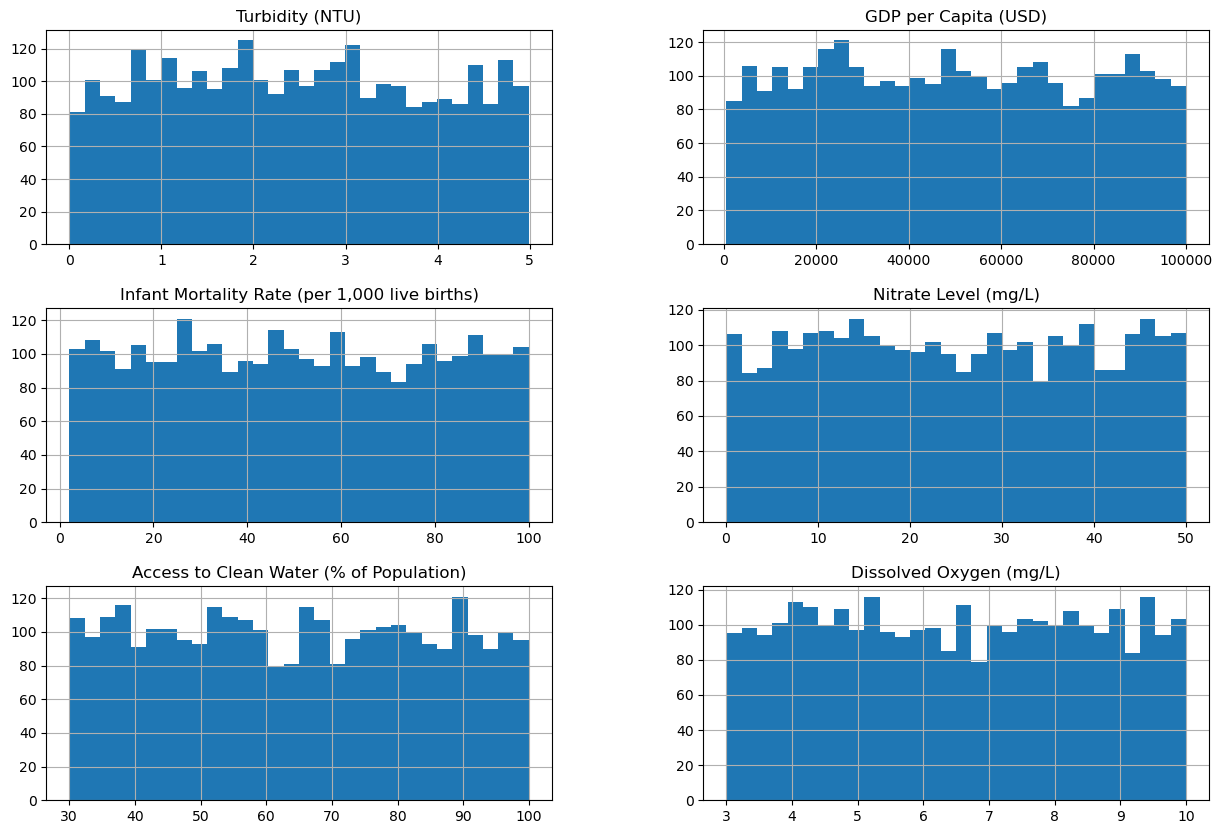

In [47]:
# to visualize with histograms
top_skewed_features = skew_vals.index[:6]
df_base[top_skewed_features].hist(bins=30, figsize=(15,10))

Notes: 
- All numeric features have very low skew
- Looking into interaction features next

In [50]:
# making a new df for feature engineering 
df_fe = df_base.copy()

# economic capacity x healthcare system
df_fe['GDP_x_Healthcare'] = df_fe['GDP per Capita (USD)'] * df_fe['Healthcare Access Index (0-100)']

# sanitation gap
df_fe['Sanitation_Gap'] = 100 - df_fe['Sanitation Coverage (% of Population)']

# urbanization x clean water access
df_fe['CleanWater_x_Urban'] = df_fe['Access to Clean Water (% of Population)'] * df_fe['Urbanization Rate (%)']

# mortality inefficiency
df_fe['Mortality_per_GDP'] = df_fe['Infant Mortality Rate (per 1,000 live births)'] / (df_fe['GDP per Capita (USD)'] + 1)

In [52]:
# make pollution index 
pollution_features = [
    'Contaminant Level (ppm)',
    'Lead Concentration (µg/L)',
    'Nitrate Level (mg/L)',
    'Bacteria Count (CFU/mL)',
    'Turbidity (NTU)'
]

# normalize ea. pollution feature to 0–1 range before summing
scaler = MinMaxScaler()
df_scaled_pollution = pd.DataFrame(
    scaler.fit_transform(df_fe[pollution_features]),
    columns=[f"scaled_{col}" for col in pollution_features]
)

# now add it to original DataFrame
df_fe = pd.concat([df_fe, df_scaled_pollution], axis=1)

# Compute pollution index as sum of scaled values
df_fe['Pollution_Index'] = df_scaled_pollution.sum(axis=1)

In [54]:
# look at a sample
df_fe[['GDP_x_Healthcare', 'Sanitation_Gap', 'CleanWater_x_Urban', 
    'Mortality_per_GDP', 'Pollution_Index']].head()

,GDP_x_Healthcare,Sanitation_Gap,CleanWater_x_Urban,Mortality_per_GDP,Pollution_Index
0,5529964.44,36.77,2842.8960,0.001335,2.621941
1,1459050.60,70.88,6569.5498,0.004489,2.956667
2,5021104.14,6.44,2571.2294,0.000563,1.879783
3,1217655.62,5.75,4088.6571,0.003069,3.016674
4,590972.83,30.77,2033.1300,0.002291,3.307111


In [56]:
# re-define numerical columns minus targets
num_cols2 = [
    col for col in df_fe.select_dtypes(include=[np.number]).columns 
    if col not in target_cols
]

# re-define categorical columns
cat_cols2 = [
    col for col in df_fe.select_dtypes(include=['object']).columns 
    if col not in target_cols
]

print("Numerical features:", num_cols2)
print("\n\nCategorical features:", cat_cols2)

Numerical features: ['Year', 'Contaminant Level (ppm)', 'pH Level', 'Turbidity (NTU)', 'Dissolved Oxygen (mg/L)', 'Nitrate Level (mg/L)', 'Lead Concentration (µg/L)', 'Bacteria Count (CFU/mL)', 'Access to Clean Water (% of Population)', 'Infant Mortality Rate (per 1,000 live births)', 'GDP per Capita (USD)', 'Healthcare Access Index (0-100)', 'Urbanization Rate (%)', 'Sanitation Coverage (% of Population)', 'Rainfall (mm per year)', 'Temperature (°C)', 'Population Density (people per km²)', 'GDP_x_Healthcare', 'Sanitation_Gap', 'CleanWater_x_Urban', 'Mortality_per_GDP', 'scaled_Contaminant Level (ppm)', 'scaled_Lead Concentration (µg/L)', 'scaled_Nitrate Level (mg/L)', 'scaled_Bacteria Count (CFU/mL)', 'scaled_Turbidity (NTU)', 'Pollution_Index']


Categorical features: ['Country', 'Region', 'Water Source Type', 'Water Treatment Method']


-----
#### Re-run Models

In [59]:
X = df_fe.drop(columns=target_cols)
y = df_fe[target_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# fit on training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [69]:
# multi-output 
multi_xgb_model.fit(X_train_processed, y_train)
multi_preds_fe = multi_xgb_model.predict(X_test_processed)

for idx, target in enumerate(y_train.columns):
    print(f"\n=== {target} ===")
    mae = mean_absolute_error(y_test[target], multi_preds_fe[:, idx])
    rmse = np.sqrt(mean_squared_error(y_test[target], multi_preds_fe[:, idx]))
    r2 = r2_score(y_test[target], multi_preds_fe[:, idx])
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.3f}")


=== Diarrheal Cases per 100,000 people ===
MAE:  127.76
RMSE: 146.71
R²:   -0.013

=== Cholera Cases per 100,000 people ===
MAE:  12.36
RMSE: 14.32
R²:   0.003

=== Typhoid Cases per 100,000 people ===
MAE:  25.34
RMSE: 29.04
R²:   -0.005


notes:
- small improvements in mae/rmse (just a bit better) suggest some added value from feature engineering, but it's still weak overall
- R^2 is still around 0 or negative, meaning the relationships are too weak to explain variation well
- The new features helped a little

In [72]:
engineered_features = [
    'GDP_x_Healthcare',
    'Sanitation_Gap',
    'CleanWater_x_Urban',
    'Mortality_per_GDP',
    'Pollution_Index'
]

# check correlations
corr_df = df_fe[engineered_features + target_cols].corr()

# engineered features vs targets
result = corr_df.loc[engineered_features, target_cols]
print(result)

                    Diarrheal Cases per 100,000 people  \
GDP_x_Healthcare                              0.004909   
Sanitation_Gap                               -0.033032   
CleanWater_x_Urban                            0.025100   
Mortality_per_GDP                             0.005281   
Pollution_Index                               0.012565   

                    Cholera Cases per 100,000 people  \
GDP_x_Healthcare                           -0.004259   
Sanitation_Gap                              0.000448   
CleanWater_x_Urban                          0.008459   
Mortality_per_GDP                           0.002367   
Pollution_Index                             0.028984   

                    Typhoid Cases per 100,000 people  
GDP_x_Healthcare                            0.046540  
Sanitation_Gap                             -0.029559  
CleanWater_x_Urban                         -0.023734  
Mortality_per_GDP                           0.016879  
Pollution_Index                        

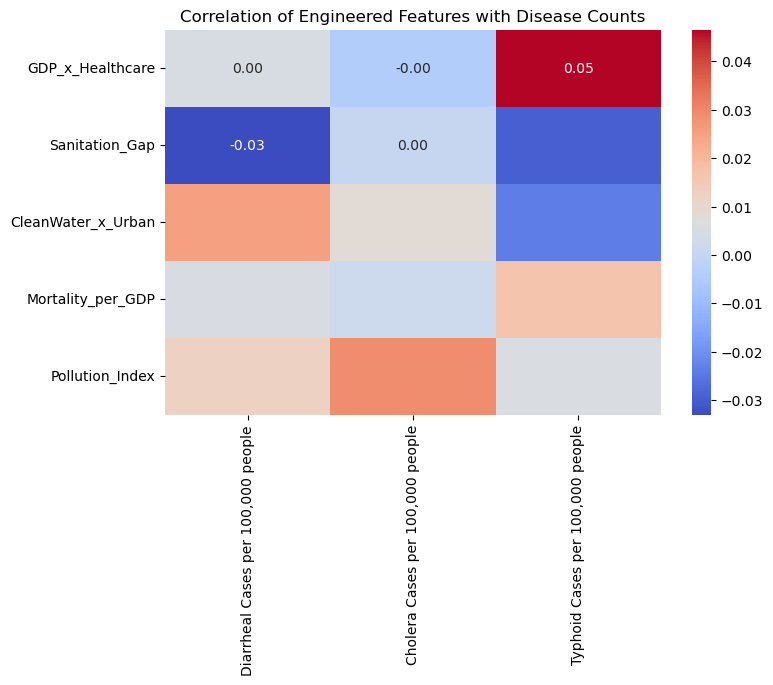

In [74]:
plt.figure(figsize=(8, 5))
sns.heatmap(result, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Engineered Features with Disease Counts')
plt.show()

------
#### Trying Other Models 
- Ridge Regression: A regularized linear model, because the data shows no strong relationships, so regularization will help avoid overfitting noise.
- LightGBM: A fast and efficient gradient boosting method that may benefit smaller, low-signal datasets with its effective split strategy
- CatBoost: A gradient boosting model that excels at handling categorical features, making it effective for datasets with meaningful categories like country and region.

In [93]:
# models
models2 = {
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "LightGBM": lgb.LGBMRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(silent=True, random_state=42)
}

# to store results
results2 = []

# loop over models and targets
for model_name, model in models2.items():
    print(f"\n=== {model_name} ===")
    for target in target_cols:
        print(f"\nTraining for target: {target}")
        
        model.fit(X_train_processed, y_train[target])
        
        y_pred = model.predict(X_test_processed)
        
        # metrics
        mae = mean_absolute_error(y_test[target], y_pred)
        rmse = np.sqrt(mean_squared_error(y_test[target], y_pred))
        r2 = r2_score(y_test[target], y_pred)
        
        print(f"MAE:  {mae:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"R²:   {r2:.3f}")
        
        # save results
        results2.append({
            "Model": model_name,
            "Target": target,
            "MAE": mae,
            "RMSE": rmse,
            "R2": r2
        })

# make results df
model_results = pd.DataFrame(results2)
display(model_results)


=== Ridge ===

Training for target: Diarrheal Cases per 100,000 people
MAE:  128.50
RMSE: 147.26
R²:   -0.020

Training for target: Cholera Cases per 100,000 people
MAE:  12.42
RMSE: 14.39
R²:   -0.006

Training for target: Typhoid Cases per 100,000 people
MAE:  25.58
RMSE: 29.38
R²:   -0.028

=== LightGBM ===

Training for target: Diarrheal Cases per 100,000 people
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6677
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 52
[LightGBM] [Info] Start training from score 249.285000


/Users/darleneeligado/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=6.40699e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/darleneeligado/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=6.40699e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/darleneeligado/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=6.40699e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/darleneeligado/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/darleneeligado/anaconda3/lib/python3

MAE:  131.76
RMSE: 153.73
R²:   -0.112

Training for target: Cholera Cases per 100,000 people
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6677
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 52
[LightGBM] [Info] Start training from score 24.282083
MAE:  12.72
RMSE: 14.85
R²:   -0.071

Training for target: Typhoid Cases per 100,000 people
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6677
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 52
[LightGBM] [Info] Start training from score 49.156667


/Users/darleneeligado/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


MAE:  26.02
RMSE: 30.12
R²:   -0.081

=== CatBoost ===

Training for target: Diarrheal Cases per 100,000 people
MAE:  131.62
RMSE: 152.99
R²:   -0.101

Training for target: Cholera Cases per 100,000 people
MAE:  12.62
RMSE: 14.76
R²:   -0.059

Training for target: Typhoid Cases per 100,000 people
MAE:  26.24
RMSE: 30.40
R²:   -0.101


,Model,Target,MAE,RMSE,R2
0,Ridge,"Diarrheal Cases per 100,000 people",128.504551,147.259405,-0.020256
1,Ridge,"Cholera Cases per 100,000 people",12.423151,14.392442,-0.006194
2,Ridge,"Typhoid Cases per 100,000 people",25.580665,29.377884,-0.028346
3,LightGBM,"Diarrheal Cases per 100,000 people",131.764209,153.730957,-0.111900
4,LightGBM,"Cholera Cases per 100,000 people",12.717639,14.847564,-0.070836
5,LightGBM,"Typhoid Cases per 100,000 people",26.015119,30.116071,-0.080674
6,CatBoost,"Diarrheal Cases per 100,000 people",131.619173,152.990731,-0.101218
7,CatBoost,"Cholera Cases per 100,000 people",12.621279,14.763097,-0.058687
8,CatBoost,"Typhoid Cases per 100,000 people",26.237264,30.402767,-0.101348


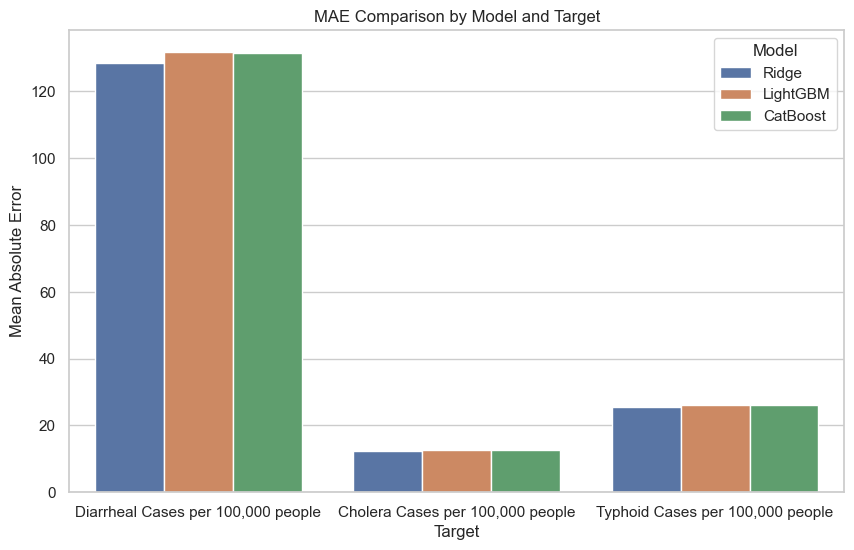

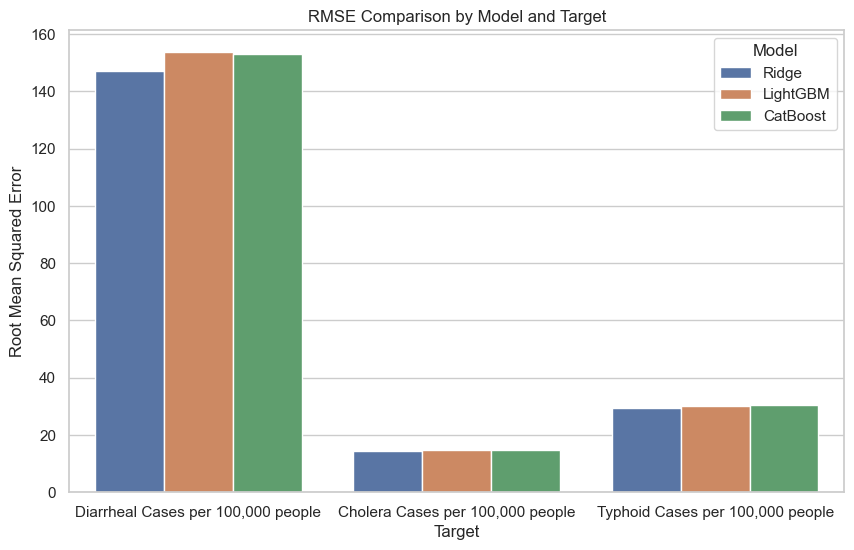

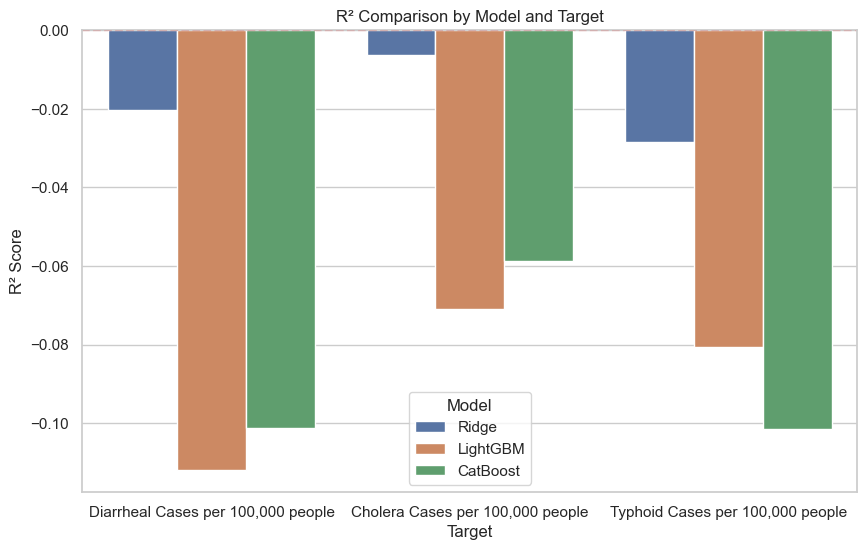

In [98]:
# model visualizations
sns.set(style="whitegrid")

# mae
plt.figure(figsize=(10, 6))
sns.barplot(x="Target", y="MAE", hue="Model", data=model_results)
plt.title("MAE Comparison by Model and Target")
plt.ylabel("Mean Absolute Error")
plt.show()

# rmse
plt.figure(figsize=(10, 6))
sns.barplot(x="Target", y="RMSE", hue="Model", data=model_results)
plt.title("RMSE Comparison by Model and Target")
plt.ylabel("Root Mean Squared Error")
plt.show()

# r squared 
plt.figure(figsize=(10, 6))
sns.barplot(x="Target", y="R2", hue="Model", data=model_results)
plt.title("R² Comparison by Model and Target")
plt.ylabel("R² Score")
plt.axhline(0, color='red', linestyle='--') 
plt.show()

Notes:
- All models had negative R^2 values, which means they performed worse than just predicting the mean
- Even advanced methods like LightGBM and CatBoost couldn't find any useful non-linear patterns
- Ridge Regression, a simpler linear model, did just as well or slightly better, showing that the data doesn't have a clear structure to take advantage of
------